# Video Compression Assignment 3

In this assignment, we will use the block-based encoding approach, where the size of a block is 8x8. Only the Luma component is considered for the following questions.

### Prerequisites

- Programming langauge: Python 3.10+ (IPython)
- Framework: Jupyter

Install dependencies from PyPI:

In [18]:
%pip install \
    --disable-pip-version-check \
    --quiet \
    numpy \
    Pillow

Note: you may need to restart the kernel to use updated packages.


## Task 1

> Fourier Transform

Please apply the Fourier Transform to the luma component of `foreman_qcif_0_rgb.bmp` and demonstrate its magnitudes in a 2-D image, as shown in the example below. Note that you need to shift the origin to the center of the image for the magnitude plot.

<div style="text-align: center;">
    <img alt="Image 1" src="https://raw.githubusercontent.com/AsherJingkongChen/video-compression-assignment-3/main/notebooks/images/1.png" width="50%">
</div>

## Solution of Task 1

## Task 2

> DCT

Please apply DCT to all the 8x8 luma blocks of `foreman_qcif_0_rgb.bmp` and use the quantization matrix below for quantization. After DCT and quantization, please apply inverse quantization and IDCT to decode all the blocks and show the decoded frame.

$$
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 \\
12 & 12 & 14 & 19 & 26 & 58 & 60 & 55 \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101 \\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99 \\
\end{bmatrix}
$$

## Solution of Task 2

### 2-D Discrete Cosine Transform

#### Forward Transform (for `NxN` block)

The formula adapted from the course slides:

$$
F(u, v) = \frac{2}{N}C(u)C(v)\sum_{x=0}^{N-1}\sum_{y=0}^{N-1}f(x, y)\cos\left(\frac{(2x+1)u\pi}{2N}\right)\cos\left(\frac{(2y+1)v\pi}{2N}\right) \\
\text{where } C(t) = \begin{cases} \frac{2}{\sqrt{N}} & \text{if } t = 0 \\ 2 \sqrt{\frac{2}{N}} & \text{otherwise} \end{cases}$$

can be simplified as:

$$
F(u, v) = \frac{8}{N^{2}}C(u)C(v)\sum_{x=0}^{N-1}\sum_{y=0}^{N-1}f(x, y)\cos\left(\frac{(2x+1)u\pi}{2N}\right)\cos\left(\frac{(2y+1)v\pi}{2N}\right) \\
\text{where } C(t) = \begin{cases} 1 & \text{if } t = 0 \\ \sqrt{2} & \text{otherwise} \end{cases}$$

#### Inverse Transform (for `NxN` block)

The formula adapted from the course slides:

$$
f(x, y) = \frac{2}{N}\sum_{u=0}^{N-1}\sum_{v=0}^{N-1}C(u)C(v)F(u, v)\cos\left(\frac{(2x+1)u\pi}{2N}\right)\cos\left(\frac{(2y+1)v\pi}{2N}\right) \\
\text{where } C(t) = \begin{cases} \frac{2}{\sqrt{N}} & \text{if } t = 0 \\ 2 \sqrt{\frac{2}{N}} & \text{otherwise} \end{cases}
$$

can be simplified as:

$$
f(x, y) = \frac{8}{N^{2}}\sum_{u=0}^{N-1}\sum_{v=0}^{N-1}C(u)C(v)F(u, v)\cos\left(\frac{(2x+1)u\pi}{2N}\right)\cos\left(\frac{(2y+1)v\pi}{2N}\right) \\
\text{where } C(t) = \begin{cases} 1 & \text{if } t = 0 \\ \sqrt{2} & \text{otherwise} \end{cases}$$

Implement the DCT and IDCT functions:

In [19]:
from numpy.typing import NDArray
from numpy import float64, uint8


def dct_forward(source: NDArray[uint8], block_size: int) -> NDArray[float64]:
    from numpy import atleast_2d, float64
    from math import sqrt, cos, pi

    source = atleast_2d(source).astype(float64)
    block_size = int(block_size)

    N = block_size
    C = 8 / N / N
    PI_2N = pi / 2 / N
    SR_2 = sqrt(2)

    target = source.copy()
    for i in range(0, target.shape[0] - N + 1, N):
        for j in range(0, target.shape[1] - N + 1, N):
            for u in range(N):
                for v in range(N):
                    a = 0.0
                    for x in range(N):
                        for y in range(N):
                            a += (
                                source[i + x, j + y]
                                * cos((2 * x + 1) * u * PI_2N)
                                * cos((2 * y + 1) * v * PI_2N)
                            )
                    target[i + u, j + v] = (
                        C
                        * (1 if u == 0 else SR_2)
                        * (1 if v == 0 else SR_2)
                        * a
                    )
    return target


def dct_inverse(source: NDArray[float64], block_size: int) -> NDArray[uint8]:
    from numpy import atleast_2d, float64, uint8
    from math import cos, pi, sqrt

    source = atleast_2d(source).astype(float64)
    block_size = int(block_size)

    N = block_size
    C = 8 / N / N
    PI_2N = pi / 2 / N
    SR_2 = sqrt(2)

    target = source.copy()
    for i in range(0, target.shape[0] - N + 1, N):
        for j in range(0, target.shape[1] - N + 1, N):
            for x in range(N):
                for y in range(N):
                    a = 0.0
                    for u in range(N):
                        for v in range(N):
                            a += (
                                (1 if u == 0 else SR_2)
                                * (1 if v == 0 else SR_2)
                                * source[i + u, j + v]
                                * cos((2 * x + 1) * u * PI_2N)
                                * cos((2 * y + 1) * v * PI_2N)
                            )
                    target[i + x, j + y] = C * a
    target = target.round().astype(uint8)
    return target

Test the DCT and IDCT functions:

In [20]:
from numpy.random import randint
from numpy import set_printoptions

mat = randint(low=0, high=256, size=(17, 8), dtype=uint8)
mat_dct = dct_forward(mat, 8)
mat_idct = dct_inverse(mat_dct, 8)

set_printoptions(precision=1)
print(mat_dct)

assert (mat == mat_idct).all()

[[1058.9  108.4  -26.7  -78.4   12.4    8.7  -12.6    1.9]
 [ 159.4   -3.2   86.9   73.9   -5.8  -32.6  -17.5   65. ]
 [ -17.1   43.1   24.3  -16.5 -108.8    6.2   21.    39.5]
 [  48.9   78.3   37.4   50.1  156.9  -45.9    4.2  117.8]
 [ -86.9   71.7  113.2   14.6   78.6  -49.7  -50.3  -39.8]
 [  31.  -143.2   27.2   -1.2  -44.3  -44.8 -143.3  -55.9]
 [  39.4  191.5  -85.2   -1.6  -20.   -32.4  -61.8  105.4]
 [ -21.6  -42.3   55.5  -49.2   80.7   42.8  -43.3   15.9]
 [1014.9  -97.1   40.    45.1   40.6   -5.   -42.9  116.3]
 [ -90.9  -76.3   67.2 -121.8   52.6  -40.1  -75.9 -113.9]
 [-135.7 -122.2    6.1 -147.6  -45.7 -132.8  -70.    13.4]
 [   8.2   10.1  -55.4  -31.2   85.2  204.4   68.7  169.9]
 [ 116.1  -81.2  110.5  -49.2  -75.1   41.1   61.3  -69.9]
 [ -57.7   16.3   78.6  -12.1  -79.7   91.6   20.5  -52.2]
 [ -26.2   35.7   -0.5   -2.4   -8.   -18.9  -88.8  -83.1]
 [ -35.2   65.1 -131.4   14.9 -101.4   53.4   11.2   58.9]
 [ 228.    63.    20.   237.   249.   180.     4.   143.

### Quantization

#### Forward Transform

$$
F'(u, v) = \text{round}\left(\frac{F(u, v)}{Q(u, v)}\right) \text{ where } Q \text{ is the quantization matrix}
$$

#### Inverse Transform

$$
F(u, v) = F'(u, v) \cdot Q(u, v) \text{ where } Q \text{ is the quantization matrix}
$$

In [21]:
from numpy.typing import NDArray
from numpy import array, float64, int64, uint8
from typing import Optional

COMMON_QUANTIZATION_MATRIX = array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ],
    dtype=uint8,
)


def quantize_forward(
    source: NDArray[float64],
    matrix: Optional[NDArray[uint8]] = None,
) -> NDArray[int64]:
    from numpy import atleast_2d, float64, uint8, int64

    source = atleast_2d(source).astype(float64)
    matrix = (
        atleast_2d(matrix).astype(uint8)
        if matrix
        else COMMON_QUANTIZATION_MATRIX
    )

    target = source.copy()
    for i in range(0, target.shape[0] - matrix.shape[0] + 1, matrix.shape[0]):
        for j in range(
            0, target.shape[1] - matrix.shape[1] + 1, matrix.shape[1]
        ):
            target[i : i + matrix.shape[0], j : j + matrix.shape[1]] = (
                source[i : i + matrix.shape[0], j : j + matrix.shape[1]]
                / matrix
            ).round()
    target = target.astype(int64)
    return target


def quantize_inverse(
    source: NDArray[int64],
    matrix: Optional[NDArray[uint8]] = None,
) -> NDArray[float64]:
    from numpy import atleast_2d, float64, uint8

    source = atleast_2d(source).astype(float64)
    matrix = (
        atleast_2d(matrix).astype(uint8)
        if matrix
        else COMMON_QUANTIZATION_MATRIX
    )

    target = source.copy()
    for i in range(0, target.shape[0] - matrix.shape[0] + 1, matrix.shape[0]):
        for j in range(
            0, target.shape[1] - matrix.shape[1] + 1, matrix.shape[1]
        ):
            target[i : i + matrix.shape[0], j : j + matrix.shape[1]] = (
                source[i : i + matrix.shape[0], j : j + matrix.shape[1]]
                * matrix
            )
    return target

Test the quantization and inverse quantization functions:

In [22]:
from numpy.random import randn
from numpy import set_printoptions

mat = randn(17, 8) * 100
mat_q = quantize_forward(mat)
mat_iq = quantize_inverse(mat_q)

set_printoptions(suppress=True)

print(abs((mat - mat_iq)).mean())
print(mat_q)

15.045141116527034
[[ 10.   11.   13.    7.    2.   -0.   -2.    1. ]
 [ -2.   17.    5.   -6.   -6.   -0.   -4.    1. ]
 [  5.   -5.    0.    1.    3.   -1.    1.   -2. ]
 [  9.   -4.   -4.   -2.    2.   -1.   -1.    1. ]
 [  1.   -2.   -1.   -0.    1.   -1.   -1.    1. ]
 [ -6.    1.    1.   -1.    2.   -1.   -0.    1. ]
 [  1.    1.    2.    0.   -1.    1.   -0.   -2. ]
 [ -0.    1.    2.   -0.    1.    1.   -0.    1. ]
 [ 10.   26.    9.    4.    2.    2.    0.   -2. ]
 [  4.   11.  -13.    7.   -6.    2.    3.   -3. ]
 [  7.    8.   -3.   -4.    3.    1.   -1.    2. ]
 [-13.    6.    2.   -3.   -1.    0.    1.   -2. ]
 [  2.    4.    4.   -1.    1.    1.    2.   -2. ]
 [  3.    0.    4.    3.   -0.    1.   -1.   -0. ]
 [  1.   -0.   -3.   -2.    0.    0.    0.    1. ]
 [  2.   -1.    1.   -1.    0.    2.    0.   -1. ]
 [132.6 -74.8 -50.9  47.4 -16.6  29.9 133.7 134.8]]


Load the image and apply the DCT and quantization:

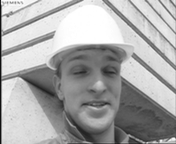

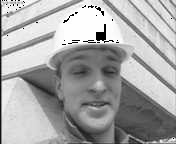

{'source_data': array([[ 32, 233, 251, ..., 212, 230, 203],
        [ 39, 212, 206, ..., 220, 226, 203],
        [ 37, 207, 187, ..., 191, 228, 200],
        ...,
        [ 14, 132, 215, ..., 176, 174, 154],
        [ 15, 132, 215, ..., 191, 193, 178],
        [ 14, 131, 212, ..., 128, 127, 118]], dtype=uint8),
 'encoded_data': array([[1531.5, -326.1, -276.4, ...,   19.8,  -16. ,    1.3],
        [  25. ,   96.2,   11.2, ...,   10.3,   -6.7,    7.3],
        [  74.9,  -58.1,  -38.7, ...,   -9.6,   -2.9,   -2.2],
        ...,
        [  -1.5,    1.6,    1.8, ...,    6. ,    8.3,    5.3],
        [  -1.7,    1.6,   -2.6, ...,   11.6,    0.8,    1. ],
        [   2.8,   -1.9,   -0.8, ...,   -0.2,   -5.4,   -1.2]]),
 'quantized_data': array([[ 96., -30., -28., ...,   0.,  -0.,   0.],
        [  2.,   8.,   1., ...,   0.,  -0.,   0.],
        [  5.,  -4.,  -2., ...,  -0.,  -0.,  -0.],
        ...,
        [ -0.,   0.,   0., ...,   0.,   0.,   0.],
        [ -0.,   0.,  -0., ...,   0.,   0.,

In [29]:
from IPython.display import display
from pathlib import Path
from PIL import Image
from numpy import asarray

source_path = Path("../resources/foreman_qcif_0_rgb.bmp").resolve()
source_image = Image.open(source_path).convert(mode="L")
source_data = asarray(source_image)
encoded_data = dct_forward(source_data, 8)
quantized_data = quantize_forward(encoded_data)
dequantized_data = quantize_inverse(quantized_data)
decoded_data = dct_inverse(dequantized_data, 8)
target_image = Image.fromarray(decoded_data, mode="L")

display(source_image)
display(target_image)

display(
    dict(
        source_data=source_data,
        encoded_data=encoded_data,
        quantized_data=quantized_data,
        dequantized_data=dequantized_data,
        decoded_data=decoded_data,
    )
)

In [24]:
%%html
<style>
/* Do not render this cell */
@media print {
  .jp-Cell.jp-Notebook-cell:last-child {
    display: none;
  }
}

:root {
  --jp-content-link-color: dodgerblue;
}
@page {
  size: A3 portrait;
  margin: 5mm;
}
@media screen {
    body {
        margin: 5mm;
    }
}
a code {
    color: var(--jp-content-link-color) !important;
}
.jp-RenderedHTMLCommon {
  font-family: Calibri, Verdana, sans-serif !important;
  font-size: 13px !important;
  font-weight: 400 !important;
  line-height: 1.35 !important;
}
code, pre {
    font-family: Monaco, monospace !important;
}
h1 {
    text-align: center !important;
}
h1, h2, h3, h4, h5, h6, strong {
    font-weight: 700 !important;
}
h2 {
  page-break-before: always;
}
pre {
  white-space: pre-wrap;
}
table, td, th, tr, tbody, thead, tfoot {
  page-break-inside: avoid !important;
}
.jp-RenderedHTMLCommon td,
.jp-RenderedHTMLCommon th,
.jp-RenderedHTMLCommon tr {
  border: 1px solid var(--md-grey-500);
}
.jp-RenderedHTMLCommon table {
  margin-left: 2em;
}
.jp-CodeCell {
    margin-bottom: 1.5em;
}
</style>